In [1]:
# Load the data for future modification.
from keras.datasets import mnist

data = mnist.load_data()

c:\users\rajki\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [78]:
# log the size of the dataset.
train_size = len(data[0][0])
test_size = len(data[1][0])

# Our data appears to be structured in the tuple form:
# ((X_train, y_train), (X_test, y_test))
X_train, y_train = data[0]
X_test, y_test = data[1]

# Check the sizes for sanity
assert len(X_train) == train_size
assert len(y_train) == train_size
assert len(X_test) == test_size
assert len(y_test) == test_size

# Explore the data format.
sample_train = X_train[0]
sample_label = y_train[0]
print(train_size, test_size)
print(sample_train.shape)
print(sample_label)

# Seems like the image is a 28 x 28, with the prediction being a number.
# There should be 10 different classes for the 10 digits, 0-9. Make sure
# this is true.
assert len(set(y_test)) == 10

60000 10000
(28, 28)
5


In [79]:
# Data visualization pre-process. Put the images into buckets based on label.
from collections import defaultdict

DATA_BUCKETS = defaultdict(list)
for i in range(len(X_train)):
    image, label = X_train[i], y_train[i]
    DATA_BUCKETS[label].append(image)

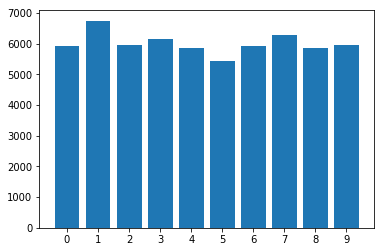

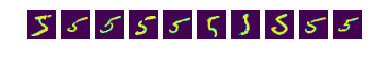

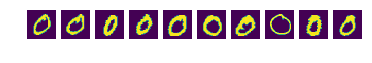

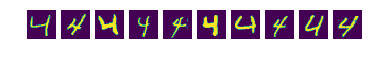

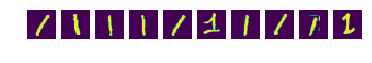

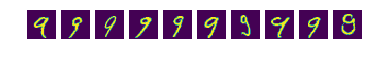

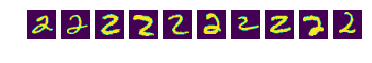

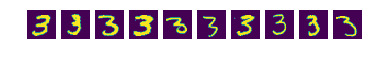

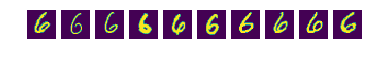

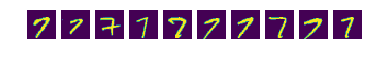

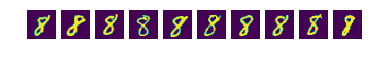

In [80]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import bar
from matplotlib.pyplot import subplots
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import cv2

# Visualize the distribution of digit examples.
x_axis = list(DATA_BUCKETS.keys())
y_axis = []
for k in x_axis:
    y_axis.append(len(DATA_BUCKETS[k]))
bar(x_axis, y_axis, tick_label=x_axis)

# Visualize some example data for each bucket.
def image_row(list_of_files):
    fig = figure()
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a = fig.add_subplot(1, number_of_files, i+1)
        image = list_of_files[i]
        imshow(image)
        axis('off')
        
# Couple of examples of different kinds of images.
for k in DATA_BUCKETS:
    image_row(DATA_BUCKETS[k][:10])

In [105]:
from keras import models
from keras import layers
from keras.utils import plot_model, to_categorical

# Let's train a simple network to recognize these numbers. For a start case, 
# let's just have a few densely connected layers, from the input image.

SHAPE = sample_train.shape

def build_network():
    network = models.Sequential()
    network.add(layers.Flatten(input_shape=SHAPE))
    network.add(layers.Dense(512, activation='relu'))
    network.add(layers.Dense(10, activation='softmax'))
    return network

def build_convolutional_network():
    network = models.Sequential()
    network.add(layers.Conv2D(32, (5, 5), input_shape=(28, 28, 1)))
    network.add(layers.Conv2D(64, (7, 7)))
    network.add(layers.Flatten())
    network.add(layers.Dense(500))
    network.add(layers.Dense(10))
    return network

# Preprocess data.
# (1) Normalize the images in X_train
# (2) Turn labels into categorical labels.
def preprocess(X, y):
    X = X/255 - 0.5
    y = to_categorical(y)
    return X, y

nn = build_convolutional_network()
print(nn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 18, 18, 64)        100416    
_________________________________________________________________
flatten_27 (Flatten)         (None, 20736)             0         
_________________________________________________________________
dense_84 (Dense)             (None, 500)               10368500  
_________________________________________________________________
dense_85 (Dense)             (None, 10)                5010      
Total params: 10,474,758
Trainable params: 10,474,758
Non-trainable params: 0
_________________________________________________________________
None


In [101]:
# Create the network. Train it for a few epochs on some data. Preprocess
# the data too.
X, y = preprocess(X_train, y_train)
X_t, y_t = preprocess(X_test, y_test)
# X = X[..., None]
network = build_network()
network.summary()
network.compile(optimizer='Adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
                
network.fit(x=X, y=y, batch_size=128, epochs=5, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_23 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_72 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 7s 137us/step - loss: 0.3796 - acc: 0.8879 - val_loss: 0.2503 - val_acc: 0.9252
Epoch 2/5
48000/48000 [==============================] - 4s 88us/step - loss: 0.1872 - acc: 0.9455 - val_loss: 0.1476 - val_acc: 0.9577
Epoch 3/5
48000/48000 [==============================] - 5s 95us/step - loss:

In [82]:
# Evaluate the accuracy
test_loss, test_acc = network.evaluate(X_t, y_t)
print(test_loss, test_acc)

10000/10000 [==============================] - 2s 229us/step
0.09350866149775684 0.9719
